In [36]:
# testing for exact TN charge gap parameter
import sys
sys.path.append("..")

from dmet.model import hubbard
from pyscf import fci
from pyscf.scf import hf
import numpy as np
from cpskit.fci import ci_slater
import scipy.linalg as la
from eomdp.fcicis import get_fciao_cis_wfns
from pyscf import ao2mo


def zero_out_ci(ci, mol, Fstrsa, Fstrsb, imp_idx, occa, occb):
    ''' 
    ci of a large fragment F
    Fstrsa, Fstrsb are cistrings of F
    imp_idx is the index of the small imp orb in F's EOs
    return a ci vector with non-zeros for configs that has imp orb (occa, occb)
    '''
    assert ci.shape[0] == len(Fstrsa)
    assert ci.shape[1] == len(Fstrsb)
    norb = mol.nao
    nci = ci.copy()
    def int2str(i):
        res = bin(i)[2:][::-1]
        return res + "0" * (norb-len(res))
    for addra in range(len(Fstrsa)):
        Fstra = int2str(Fstrsa[addra])
        if Fstra[imp_idx] != occa:
            nci[addra,:] = 0
            continue
        for addrb in range(len(Fstrsb)):
            Fstrb = int2str(Fstrsb[addrb])
            if Fstrb[imp_idx] != occb:
                nci[addra, addrb] = 0
    return nci

def get_matching_fci(ci, imp_idx, mol, normalize=True, debug=False):
    '''
    get fci vectors form the exact fci vector that match the f configs
    '''
    Fstrs = fci.cistring.make_strings(range(mol.nao), mol.nelectron//2)
    c = list()
    for occa in ['1', '0']:
        for occb in ['1', '0']:
            # extract the states where F config consistent with this f config
            cP_ = zero_out_ci(ci, mol, Fstrs, Fstrs, imp_idx, occa, occb)
            if normalize:
                c.append(cP_ / la.norm(cP_))
            else:
                c.append(cP_)
    return c

def get_cgintens(civec, norb, nelec):   
    r'''
    .. math::
        \xi = \sum\limits_{I^\alpha I^\beta} N(I^\alpha I^\beta) |\psi_{I^\alpha I^\beta}| ^ 2
    '''

    def get_cgnum(a, b, norb):

        c = a & b
        alst = [c&(2**x) for x in range(norb)]
        k = 0

        for i in alst:
            if i != 0: k += 1
        del alst
        return k

    strings = fci.cistring.make_strings(range(norb), nelec)

    intens = 0

    for a, stra in enumerate(strings):
        for b, strb in enumerate(strings):
            cgnum = get_cgnum(stra, strb, norb)
            psi = civec[a,b]
            intens += cgnum * psi * psi.conj()
    
    return intens

def get_ppg_param(ciext, cigs, norb, nelec, corrl=1.):
    _, dm2ab = fci.rdm.make_rdm12_spin1('FCItdm12kern_ab', ciext, cigs,
                                    norb, (nelec, nelec), None, 0)
    dm1a, dm1b = fci.direct_spin1.trans_rdm1s(ciext, cigs, norb, (nelec, nelec))

    propaga = dm1a - np.einsum("ijji->ij", dm2ab)
    propagb = dm1b - np.einsum("jiij->ij", dm2ab)

    pref = [[min((i-j)%norb, (j-i)%norb) for i in range(norb)] for j in range(norb)]

    pref = np.array(pref)

    return np.einsum("ij,ij->", propaga**2, pref) / np.einsum("ij->", propaga**2)

def get_cgintens_from_2rdm(civec, norb, nelec):

    dm = fci.rdm.make_rdm12_spin1('FCItdm12kern_ab', civec, civec,
                                    norb, (nelec, nelec), None, 0)
    return np.einsum("iiii->", dm)

def hs_1imp(wfnlst, nocc, nvir, h1e, eri):  # for fci wave-function list

    nstate = len(wfnlst)
    
    h = np.zeros((nstate, nstate))
    s = np.zeros((nstate, nstate))

    for i in range(nstate):

        cibra = wfnlst[i]
        for j in range(nstate):

            ciket = wfnlst[j]

            s[i,j] += np.einsum("ij,ij->", cibra.conj(), ciket)
            dm1, dm2 = fci.direct_spin1.trans_rdm12(cibra, ciket, nocc+nvir, (nocc,nocc))
            h[i,j] += np.einsum("ij,ij->", h1e, dm1) + .5 * np.einsum("ijkl,ijkl->", eri, dm2)

    return h, s

def FCI_Atomic(mf): 
    # imitating pyscf.fci.__init__.FCI(), reset h1e, eri and ci0 to SITE basis.

    mol = mf.mol
    mo_c = mf.mo_coeff
    h1e = mf.get_hcore()
    norb = mo_c.shape[1]
    eri = mf._eri
    nelec = getattr(mf, 'nelec', mol.nelec)
    mo_c_occ = mf.mo_coeff[:,np.where(mf.mo_occ==2)[0]]
    ci0 = ci_slater(norb, nelec, (mo_c_occ, mo_c_occ))

    fcisolver = fci.direct_spin1.FCISolver(mol)
    fcisolver_class = fcisolver.__class__
    class CISolver(fcisolver.__class__):
        def __init__(self, mol=None):
            fcisolver_class.__init__(self, mol)
            self.orbsym = None

        def kernel(self, h1e=h1e, eri=eri, norb=norb, nelec=nelec, ci0=ci0, ecore=0., **kwargs):
            return fcisolver_class.kernel(self, h1e, eri, norb, nelec, ci0,
                                          ecore=ecore, **kwargs)
    
    cisolver = CISolver(mol)
    cisolver.__dict__.update(fcisolver.__dict__)
    cisolver.orbsym = None
    return cisolver

mixint_lst = [[], [], [], []]
mixext_lst = [[], [], [], []]

def calc(U, ny):

    mol = hubbard.HubbardMole(1, ny, 1, U)
    mol.nelectron = ny
    nocc = nvir = nelec = ny // 2
    norb = ny
    mf = hubbard.RHF_SpinHubbard(mol)
    mf.pbc = True
    mf.kernel()

    fcisolver = FCI_Atomic(mf)    # change ci into LO basis
    fullE, fullci = fcisolver.kernel(nroots=10)
    print("FCI = ", fullE)
    spinoplst = [round(fci.spin_op.spin_square(cis, norb, (nelec, nelec))[0]) for cis in fullci]
    print("S^2 of FCI vectors: ", spinoplst)
    ci = fullci[0]

    # save the intensity of GS
    # save the intensity of FCI first excited states
    mixext_lst[3].append(fullE[1] - fullE[0])
    mixint = get_ppg_param(fullci[1], ci, norb, nelec)
    print("Distance-weighed Spin-Flip param for first triplet FCI: ", mixint)
    mixint_lst[3].append(mixint)


    eri = ao2mo.restore(1, mf._eri, ny)
    h1e = mf.get_hcore()

    dimHf = 4   # dimension of Hilbert space
    simps = [0] * ny

    wfnlst_TN = []
    
    for i in range(len(simps)):
        cs = get_matching_fci(ci, i, mol)
        for j in range(dimHf):
            wfnlst_TN.append(cs[j])

    wfnlst_EOM = get_fciao_cis_wfns(ci, nocc, nvir, mf.mo_coeff)

    wfnlst = wfnlst_TN + wfnlst_EOM # merge the EOM and TN basis sets
    exact_H, exact_S = hs_1imp(wfnlst, nocc, nvir, h1e, eri)

    ranglst = [range(len(wfnlst_TN)), range(len(wfnlst_TN), len(wfnlst)), range(len(wfnlst))]

    for i, rang in enumerate(ranglst):
        print("Calc ansatz {} ...".format(i+1))

        exact_Sp = exact_S[np.ix_(rang, rang)]
        exact_Hp = exact_H[np.ix_(rang, rang)]

        wS_exact, vS_exact = la.eigh(exact_Sp)
        mask = wS_exact > 1e-5
        S_proj = vS_exact.T[mask] @ (exact_Sp+exact_Sp.T)/2 @ vS_exact[:,mask]
        H_proj = vS_exact.T[mask] @ (exact_Hp+exact_Hp.T)/2 @ vS_exact[:,mask]
        wHp_exact, vHp_exact = hf.eig(H_proj, S_proj)   # solve in truncated area

        print("Energy for Ansatz {} = ".format(i+1), wHp_exact[:10])
        mixext_lst[i].append(wHp_exact[1] - wHp_exact[0])

        coeff_in_basis = vS_exact[:,mask] @ vHp_exact

        wfnbasis = np.array(wfnlst)[rang,:,:]

        res_wfn = np.einsum("iab,ij->jab", wfnbasis, coeff_in_basis)
        spinoplst = [round(fci.spin_op.spin_square(res_wfn[i], norb, (nelec, nelec))[0]) for i in range(10)]
        print("S^2 for Ansatz {}: ".format(i+1), spinoplst)
        ppgparam = get_ppg_param(res_wfn[1], ci, norb, nelec)
        print("Distance-weighed Spin-Flip param for Ansatz {} = ".format(i+1), ppgparam)

        mixint_lst[i].append(ppgparam)


ny = 6

ulst = np.linspace(1, 50, 50)
for U in ulst: calc(U, ny)



converged SCF energy = -6.5


Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67a68280> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a68ee0>


FCI =  [-6.60115829 -4.94491687 -4.76688967 -4.76688967 -4.69363464 -3.94241203
 -3.94241203 -3.72015979 -3.72015979 -3.21489276]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.8325671112772365
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-6.60115829 -4.75446911 -4.75446911 -4.4469502  -4.40622344 -4.40622344
 -3.91758124 -3.91758123 -3.38426868 -3.24169535]
S^2 for Ansatz 1:  [0, 2, 2, 2, 0, 0, 2, 2, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  1.1630320479179075
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-6.60115829 -4.93114251 -4.70454978 -4.70454977 -4.53095382 -4.53025027
 -4.37121992 -4.37121991 -4.25848581 -3.88603277]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 0, 0, 0, 0, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.8470522180756305
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-6.60115829 -4.93354637 -4.75998693 -4.75998692 -4.53095382 -4.53025027
 -4.40927955 -4.40927955 -4.25827341 -3.93623735]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904100> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6765dfd0>


FCI =  [-5.40945685 -4.0963821  -3.7565067  -3.7565067  -3.73239653 -3.12521306
 -3.12521306 -2.81625559 -2.81625559 -2.55682722]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.6269799370472859
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-5.40945685 -3.72113133 -3.71173215 -3.71173211 -3.02565255 -3.02565251
 -2.92548994 -2.9254899  -1.61766747 -1.61766739]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.5958944965842359
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-5.40945685 -4.05354763 -3.4809911  -3.48099107 -3.12026505 -3.10906265
 -2.87509991 -2.87509987 -2.81448525 -2.81448522]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 0, 2, 2, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.6508446388436964
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-5.40945685 -4.06690259 -3.73584755 -3.73584749 -3.12026505 -3.10906265
 -3.10478848 -3.10478842 -2.93244826 -2.93244821]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6735e460> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677dd8b0>


FCI =  [-4.43335361 -3.42472915 -3.03176891 -2.9836321  -2.9836321  -2.5277994
 -2.5277994  -2.19421177 -2.19421177 -2.05196468]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.49709998431231267
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-4.43335361 -3.13769956 -2.90073135 -2.90073132 -2.35026597 -2.35026596
 -1.50534069 -1.5053406  -0.10413175 -0.10413172]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.5281903470375794
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-4.43335361 -3.33759188 -2.31751046 -2.31751045 -1.9627507  -1.96275066
 -1.75796898 -1.70465016 -1.31937977 -1.31937975]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.529047941270824
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-4.43335361 -3.38258164 -2.95004821 -2.95004816 -2.50083502 -2.50083497
 -1.75796898 -1.70465016 -1.51139379 -1.51139367]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904520> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6735e460>


FCI =  [-3.66870618 -2.89838147 -2.51637687 -2.42291126 -2.42291126 -2.09275383
 -2.09275383 -1.76902482 -1.76902482 -1.68447136]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4326066033495164
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-3.66870618 -2.67130121 -2.31434913 -2.31434905 -1.88015842 -1.88015839
 -0.10145273 -0.10145263  1.32180644  1.32180653]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.4788336512047289
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-3.66870618 -2.74078544 -1.19734975 -1.19734967 -1.14283733 -1.14283721
 -0.43211945 -0.28843047  0.12539866  0.12539872]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.4631899509372932
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-3.66870618 -2.85010072 -2.38020479 -2.38020474 -2.06771875 -2.06771869
 -0.43211945 -0.28843047 -0.10292076 -0.10292064]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904520> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6eb87b50>


FCI =  [-3.08770676 -2.48686651 -2.13127691 -2.02075922 -2.02075922 -1.7704692
 -1.7704692  -1.47113273 -1.47113273 -1.41746074]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4098612795762701
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-3.08770676 -2.29945361 -1.90460069 -1.90460053 -1.56202342 -1.5620234
  1.30128305  1.30128355  2.67628288  2.67628295]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.4472540926837776
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-3.08770676 -2.23555625 -0.40746847 -0.40746829 -0.1072187  -0.10721868
  0.86380501  1.13504537  1.51488676  1.52353705]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.42981578453316943
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-3.08770676 -2.43678299 -1.97275983 -1.97275965 -1.74870076 -1.74870072
  0.86380501  1.13504537  1.30071764  1.30071811]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68d4eeb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac68d4e5e0>


FCI =  [-2.64851756 -2.16342845 -1.83805413 -1.72630329 -1.72630329 -1.52638607
 -1.52638607 -1.25456083 -1.25456083 -1.21874398]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4059821218821209
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.64851756 -2.00357937 -1.6137388  -1.61373876 -1.338504   -1.33850386
  2.68948673  2.68948692  3.96915812  3.96915825]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.42721449791967436
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.64851756 -1.81011515  0.25404854  0.25404862  0.95790109  0.95790118
  2.12968142  2.53750247  2.80150603  2.87284571]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.41215308042996385
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.64851756 -2.1139613  -1.67590262 -1.67590252 -1.50641242 -1.50641234
  2.12968142  2.53750247  2.59728352  2.68104265]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6f4f9a30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6f251f40>


FCI =  [-2.31185008 -1.9064776  -1.61020712 -1.50390603 -1.50390603 -1.33727193
 -1.33727193 -1.09138722 -1.09138722 -1.06650782]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40820869389045517
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.31185008 -1.76724304 -1.399041   -1.39904096 -1.17214281 -1.17214278
  4.04386477  4.04386496  5.20915681  5.20915689]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.41360729990592127
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.31185008 -1.45410317  0.85495508  0.85495511  1.99828636  1.99828652
  3.36404637  3.89715871  4.04415402  4.16516479]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.40169503968958054
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.31185008 -1.85885623 -1.45299836 -1.45299832 -1.31779396 -1.31779395
  3.36404637  3.72448825  3.89715871  4.02012814]
S^2 for Ans

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67691340> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac676912b0>


FCI =  [-2.04813089 -1.69956461 -1.42956154 -1.33084623 -1.33084623 -1.18753787
 -1.18753787 -0.9646148  -0.9646148  -0.94674461]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41147415842081414
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.04813089 -1.57656314 -1.23431687 -1.2343168  -1.04247257 -1.04247253
  5.3541704   5.3541709   6.40550434  6.40550444]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.40361735425148737
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.04813089 -1.15493104  1.40849465  1.40849478  3.01403542  3.01403561
  4.56757745  5.20778618  5.24822589  5.3099193 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 0, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.39468150676020186
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.04813089 -1.65432856 -1.28057763 -1.28057757 -1.16794352 -1.1679435
  4.56757745  4.82482115  5.20778618  5.29402262]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6794ffd0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67691340>


FCI =  [-1.83692691 -1.53053306 -1.2836152  -1.19268607 -1.19268607 -1.06662144
 -1.06662144 -0.86356555 -0.86356555 -0.85035884]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41422692969868896
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.83692691 -1.42068402 -1.1039187  -1.10391868 -0.93814269 -0.93814261
  6.61969084  6.61969121  7.56693893  7.56693908]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3958284798518896
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.83692691 -0.9003662   1.92588573  1.92588578  4.0065361   4.0065362
  5.74301921  6.41985485  6.42759005  6.42759006]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3894667903541075
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.83692691 -1.48784037 -1.1437103  -1.14371028 -1.04675116 -1.04675114
  5.74301921  5.90994019  6.42177668  6.42177685]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac682128e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac68212d60>


FCI =  [-1.66436273 -1.39049654 -1.1636734  -1.0800014  -1.0800014  -0.96724823
 -0.96724823 -0.78127889 -0.78127889 -0.77127646]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4161790678318102
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.66436273 -1.29148522 -0.99813027 -0.99813019 -0.85229741 -0.85229736
  7.84483936  7.84483944  8.70085314  8.7008532 ]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3895019518152837
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.66436273 -0.6802647   2.4158051   2.41580523  4.97813462  4.9781349
  6.89403217  7.5240205   7.5240205   7.5648351 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3852976355161032
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.66436273 -1.35030673 -1.03266455 -1.03266451 -0.94715068 -0.94715066
  6.89403217  6.98481594  7.48025341  7.5240205 ]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68d4edf0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6f4f9a30>


FCI =  [-1.52090454 -1.27295063 -1.06359368 -0.98643373 -0.98643373 -0.88430984
 -0.88430984 -0.71305603 -0.71305603 -0.70531791]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41742008761503335
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.52090454 -1.18298075 -0.910608   -0.91060797 -0.78044538 -0.78044534
  9.03566318  9.03566336  9.81311434  9.81311442]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.384219390362685
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.52090454 -0.48680948  2.88470354  2.88470375  5.93151904  5.93151927
  8.02433048  8.60391269  8.60391269  8.68812219]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.38180483045619173
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.52090454 -1.23512868 -0.94089328 -0.94089327 -0.86410399 -0.86410398
  8.02433048  8.05168384  8.51287772  8.60391269]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68d4edf0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6f4f9a30>


FCI =  [-1.39985748 -1.17309534 -0.97895849 -0.90755552 -0.90755552 -0.81414531
 -0.81414531 -0.65562453 -0.65562453 -0.64952636]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41811526575962416
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.39985748 -1.09074928 -0.83702382 -0.8370238  -0.71946746 -0.71946738
 10.19807888 10.19807892 10.9082456  10.90824563]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3797222773086667
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.39985748 -0.31413894  3.33732289  3.33732315  6.86930521  6.86930542
  9.13726723  9.67087927  9.67087928  9.77945853]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3787917809684999
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.39985748 -1.13746819 -0.86385567 -0.86385566 -0.79395778 -0.79395775
  9.11177303  9.13726723  9.53980847  9.67087927]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6735e460> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac68d4edf0>


FCI =  [-1.29640765 -1.08734713 -0.90653225 -0.84019614 -0.84019614 -0.75407849
 -0.75407849 -0.60664205 -0.60664205 -0.60175772]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4184163235533407
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.29640765 -1.01149338 -0.77431711 -0.77431704 -0.66710973 -0.66710968
 11.3372207  11.33722086 11.98970163 11.98970171]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.37583852591325984
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.29640765 -0.15787841  3.77715952  3.77715996  7.79384319  7.7938434
 10.23570439 10.72765286 10.7276529  10.81795076]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.37614396080074475
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.29640765 -1.0537331  -0.79831436 -0.79831429 -0.73401945 -0.73401942
 10.16594718 10.23570439 10.5624379  10.72765286]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68212f40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6eaf3280>


FCI =  [-1.2070146  -1.01299534 -0.84390277 -0.78202876 -0.78202876 -0.70211616
 -0.70211616 -0.5643914  -0.5643914  -0.56042296]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41844191372113526
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.2070146  -0.94272194 -0.72025983 -0.72025983 -0.62169708 -0.62169703
 12.45731765 12.45731771 13.06012485 13.06012487]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.372446744740406
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.2070146  -0.01474315  4.20681706  4.20681741  8.70715754  8.70715799
 11.3220186  11.77629882 11.77629884 11.85146023]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.37378840081094766
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.2070146  -0.98121873 -0.74190441 -0.74190439 -0.68227314 -0.68227313
 11.21491603 11.3220186  11.5817404  11.77629882]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6eaf3280> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a11040>


FCI =  [-1.12902061 -0.94796203 -0.78924142 -0.73130902 -0.73130902 -0.65674792
 -0.65674792 -0.5275869  -0.5275869  -0.52432148]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41827934208540823
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.12902061 -0.88252687 -0.67319137 -0.67319135 -0.58195727 -0.58195724
 13.56177262 13.56177264 14.12154975 14.12154977]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.36945748068783923
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.12902061  0.11775903  4.62825952  4.62825963  9.61095449  9.61095488
 12.39815933 12.81838788 12.8183879  12.88090393]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3716746817694615
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.12902061 -0.91785955 -0.6928615  -0.69286148 -0.63718652 -0.63718651
 12.25928885 12.39815933 12.59841527 12.81838788]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6eaf3280> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677ddd60>


FCI =  [-1.06039367 -0.89063329 -0.74114039 -0.68670455 -0.68670455 -0.61681091
 -0.61681091 -0.49524801 -0.49524801 -0.49253056]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4179911196182447
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.06039367 -0.829427   -0.63184832 -0.6318483  -0.546907   -0.54690698
 14.65330198 14.65330202 15.1755576  15.17555763]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3668026612075153
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.06039367  0.24154288  5.04298829  5.04298836 10.50665684 10.50665714
 13.46571874 13.85512639 13.85512642 13.90698622]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.36976569017798905
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.06039367 -0.86205644 -0.64984396 -0.64984395 -0.59757806 -0.59757806
 13.29960628 13.46571874 13.61297633 13.85512639]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6eaf3280> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6765dfd0>


FCI =  [-0.99955467 -0.83973995 -0.69850025 -0.64718082 -0.64718082 -0.58139686
 -0.58139686 -0.46661454 -0.46661454 -0.46433009]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4176214265355642
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.99955467 -0.78225753 -0.59525298 -0.59525294 -0.51577486 -0.51577481
 15.73407214 15.73407221 16.22339011 16.22339018]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3644291778365339
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.99955467  0.35809864  5.45216691  5.45216735 11.39544588 11.39544626
 14.5259978  14.88745108 14.8874511  14.93025662]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3680326832126615
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.99955467 -0.81255517 -0.61181463 -0.6118146  -0.56252449 -0.56252448
 14.33634219 14.5259978  14.6258098  14.88745108]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac677d8490> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6eaf3280>


FCI =  [-0.94525851 -0.79427216 -0.66045119 -0.61192273 -0.61192273 -0.54978693
 -0.54978693 -0.44108841 -0.44108841 -0.4391504 ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41720126981248024
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.94525851 -0.7400915  -0.56263703 -0.56263702 -0.48794762 -0.48794761
 16.80581846 16.80581858 17.26603305 17.26603311]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3622947986632305
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.94525851  0.46860056  5.85670935  5.85670943 12.2783034  12.27830348
 15.58006307 15.9160977  15.91609771 15.95115009]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.36645263074864015
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.94525851 -0.76836007 -0.57795964 -0.57795963 -0.53129528 -0.53129528
 15.36991151 15.58006307 15.63721169 15.9160977 ]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68d4edf0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677d8490>


FCI =  [-0.89651066 -0.75341762 -0.62629678 -0.58027968 -0.58027968 -0.52140534
 -0.52140534 -0.41819293 -0.41819293 -0.41653522]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4167524016212588
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.89651066 -0.7021829  -0.53338868 -0.53338867 -0.4629322  -0.4629322
 17.8699374  17.86993742 18.30427669 18.30427671]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.36036543974638224
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.89651066  0.57398478  6.25734152  6.25734157 13.15604483 13.15604488
 16.62879274 16.94165038 16.94165039 16.97001548]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3650065976127222
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.89651066 -0.72867175 -0.54763193 -0.54763192 -0.50330579 -0.50330578
 16.40067369 16.62879274 16.64741318 16.94165038]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678714f0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac68d4edf0>


FCI =  [-0.85250734 -0.71651632 -0.5954733  -0.55172623 -0.55172623 -0.49578587
 -0.49578587 -0.39754361 -0.39754361 -0.39611503]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4162898631818295
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.85250734 -0.66792527 -0.50701473 -0.50701472 -0.44032779 -0.44032778
 18.9275615  18.92756155 19.33876123 19.33876127]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.35861321278409514
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.85250734  0.6750058   6.65464704  6.6546471  14.02935188 14.02935196
 17.67291407 17.96457803 17.96457804 17.98713601]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.36367874716566845
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.85250734 -0.69284175 -0.52031075 -0.52031074 -0.47808306 -0.47808306
 17.42894533 17.65659726 17.67291407 17.96457803]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6794ffd0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac68d4edf0>


FCI =  [-0.81259214 -0.68302692 -0.5675199  -0.52583354 -0.52583354 -0.47254717
 -0.47254717 -0.37882705 -0.37882705 -0.3775875 ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41582409296451744
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.81259214 -0.63682083 -0.48311337 -0.48311337 -0.4198055  -0.4198055
 19.97961552 19.97961556 20.37000986 20.37000988]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3570150786631838
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.81259214  0.77227805  7.04910006  7.04910011 14.89879573 14.89879584
 18.71303256 18.98526071 18.98526072 19.00274406]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3624556658444194
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.81259214 -0.66033896 -0.49557249 -0.49557248 -0.45524085 -0.45524085
 18.45499893 18.66491108 18.71303256 18.98526071]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678718e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678714f0>


FCI =  [-0.77622382 -0.65250156 -0.54205633 -0.50224825 -0.50224825 -0.45137449
 -0.45137449 -0.3617853  -0.3617853  -0.36070304]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41536222630016073
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.77622382 -0.60845749 -0.46135404 -0.46135404 -0.4010931  -0.4010931
 21.02686072 21.02686076 21.39845413 21.39845414]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3555518113051321
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.77622382  0.86630672  7.44108919  7.44108925 15.76485773 15.76485775
 19.74965547 20.00400949 20.00400949 20.01703223]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.36132588172328833
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.77622382 -0.63072453 -0.47306915 -0.47306915 -0.43446078 -0.43446078
 19.4790728  19.6724743  19.74965547 20.00400949]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67a116a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678718e0>


FCI =  [-0.74295221 -0.62456674 -0.51876622 -0.48067662 -0.48067662 -0.43200583
 -0.43200583 -0.34620414 -0.34620414 -0.34525379]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4149090619869572
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.74295221 -0.58249133 -0.44146235 -0.44146233 -0.38396338 -0.38396338
 22.06992833 22.06992841 22.42445288 22.42445296]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.35420723778782387
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.74295221  0.95751061  7.830936    7.83093625 16.62794516 16.62794541
 20.78321019 21.0210811  21.02108112 21.03016157]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.36027951117268164
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.74295221 -0.60363286 -0.4525123  -0.45251229 -0.41547826 -0.41547825
 20.50137454 20.67938534 20.78321019 21.0210811 ]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6765deb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a11df0>


FCI =  [-0.71239989 -0.59890864 -0.49738427 -0.46087253 -0.46087253 -0.41422142
 -0.41422142 -0.33190427 -0.33190427 -0.33106534]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41446777951514524
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.71239989 -0.55863319 -0.42320861 -0.4232086  -0.36822533 -0.36822533
 23.10934489 23.10934493 23.44830657 23.44830664]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3529676637200317
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.71239989  1.04623994  8.21890889  8.21890908 17.48840475 17.48840478
 21.81405888 22.03668922 22.03668923 22.04226773]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3593079887637868
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.71239989 -0.57875707 -0.43366083 -0.43366082 -0.3980717  -0.3980717
 21.52208522 21.68572592 21.81405888 22.03668922]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67691400> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67691f70>


FCI =  [-0.68424815 -0.57526177 -0.47768645 -0.44262822 -0.44262822 -0.39783559
 -0.39783559 -0.31873445 -0.31873445 -0.31799026]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4140403323022755
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.68424815 -0.53663826 -0.40639925 -0.40639924 -0.35371727 -0.35371725
 24.14555343 24.14555346 24.47026883 24.47026888]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3518213986539557
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.68424815  1.13278953  8.60523314  8.60523332 18.34653246 18.34653256
 22.84251008 23.051013   23.05101301 23.05346595]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.35840384996317404
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.68424815 -0.55583778 -0.41631175 -0.41631174 -0.38205421 -0.3820542
 22.54136392 22.69156452 22.84251008 23.051013  ]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68d4edf0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6ece3ee0>


FCI =  [-0.658226   -0.55340011 -0.45948228 -0.42576716 -0.42576716 -0.38269043
 -0.38269043 -0.30656629 -0.30656629 -0.30590316]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4136279283534431
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.658226   -0.51629796 -0.39086994 -0.39086993 -0.34030139 -0.34030137
 25.17892903 25.17892905 25.49055516 25.4905552 ]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.35075841631288873
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.658226    1.21740935  8.9900998   8.99010008 19.20258287 19.20258296
 23.86882811 24.06385475 24.06420373 24.06420374]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3575605661568431
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.658226   -0.53465427 -0.40029299 -0.40029297 -0.36726704 -0.36726704
 23.55934795 23.696959   23.86882811 24.06420373]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678c2f10> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677d84f0>


FCI =  [-0.6341016  -0.53313003 -0.44260882 -0.41013839 -0.41013839 -0.36865085
 -0.36865085 -0.29529005 -0.29529005 -0.29469667]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4132310542413866
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.6341016  -0.49743354 -0.37648025 -0.37648023 -0.32785964 -0.32785963
 26.20979009 26.20979014 26.50934939 26.50934944]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34977006470831645
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.6341016   1.30031267  9.37367148  9.37367158 20.05677549 20.05677572
 24.89324042 25.07351878 25.07638998 25.07638999]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.35677239857027365
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.6341016  -0.51501764 -0.38545762 -0.38545761 -0.35357466 -0.35357465
 24.57616154 24.70195852 24.89324042 25.07638998]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678c2f10> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677d84f0>


FCI =  [-0.61167549 -0.51428478 -0.4269259  -0.39561206 -0.39561206 -0.35560056
 -0.35560056 -0.28481144 -0.28481144 -0.28427839]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4128499200041007
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.61167549 -0.47989093 -0.36310952 -0.36310952 -0.31629028 -0.31629027
 27.23841048 27.23841049 27.5268099  27.52680991]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3488488453676787
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.61167549  1.38168264  9.75608753  9.75608774 20.90930074 20.90930093
 25.9159439  26.0825313  26.08768171 26.08768172]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3560342911607119
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.61167549 -0.49676529 -0.37167957 -0.37167956 -0.34086055 -0.34086054
 25.59191055 25.70660527 25.9159439  26.08768171]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6820d220> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678c2f10>


FCI =  [-0.59077509 -0.49671998 -0.4123123  -0.38207589 -0.38207589 -0.34343899
 -0.34343899 -0.27504894 -0.27504894 -0.27456835]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4124843691388385
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.59077509 -0.46353668 -0.35065352 -0.35065352 -0.30550517 -0.30550516
 28.26502495 28.26502503 28.54307319 28.54307323]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34798820777368467
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.59077509  1.46167733 10.13746761 10.13746794 21.76032439 21.76032466
 26.93710943 27.09095603 27.0981735  27.09817351]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3553417653275246
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.59077509 -0.47975654 -0.35884999 -0.35884999 -0.32902409 -0.32902408
 26.60669164 26.71093548 26.93710943 27.0981735 ]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6f4f9a30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677f1610>


FCI =  [-0.57125039 -0.48031005 -0.39866265 -0.36943231 -0.36943231 -0.33207869
 -0.33207869 -0.26593177 -0.26593177 -0.26549699]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41213410987436794
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.57125039 -0.44825462 -0.33902171 -0.33902171 -0.29542759 -0.29542759
 29.28983702 29.28983716 29.55825792 29.55825803]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34718243715508734
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.57125039  1.54043375 10.51791619 10.5179168  22.60999107 22.60999122
 27.95688628 28.09884857 28.10794707 28.10794707]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3546908498561469
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.57125039 -0.46386902 -0.34687446 -0.34687445 -0.31797791 -0.3179779
 27.62058848 27.71498064 27.95688628 28.10794707]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac68212d60> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6eaf3280>


FCI =  [-0.55297034 -0.46494519 -0.38588492 -0.35759611 -0.35759611 -0.32144328
 -0.32144328 -0.25739814 -0.25739814 -0.25700354]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4117986092305487
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.55297034 -0.43394316 -0.32813509 -0.32813507 -0.28599051 -0.2859905
 30.31302459 30.31302509 30.57246815 30.57246835]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34642649085618143
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.55297034  1.61807172 10.89752362 10.8975239  23.45842813 23.45842866
 28.9754054  29.10625768 29.11707344 29.11707346]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.35407800372945536
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.55297034 -0.44899586 -0.33567062 -0.3356706  -0.3076458  -0.30764579
 28.63368255 28.71876808 28.9754054  29.11707344]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6765dfd0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6eaf3280>


FCI =  [-0.53581998 -0.45052907 -0.37389842 -0.34649257 -0.34649257 -0.31146574
 -0.31146574 -0.24939389 -0.24939389 -0.24903469]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4114774709185368
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.53581998 -0.4205131  -0.31792445 -0.31792444 -0.27713496 -0.27713495
 31.3347423  31.33474243 31.58579424 31.58579433]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3457159514653889
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.53581998  1.69469571 11.27636975 11.27636985 24.3057474  24.30574758
 29.99278163 30.11322653 30.12561471 30.12561472]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.353500084491514
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.53581998 -0.43504331 -0.32516639 -0.32516638 -0.29796101 -0.297961
 29.6460288  29.72232195 29.99278163 30.12561471]
S^2 for Ansatz 3:

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904520> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6765dfd0>


FCI =  [-0.51969805 -0.43697678 -0.36263207 -0.33605588 -0.33605588 -0.30208706
 -0.30208706 -0.24187135 -0.24187135 -0.24154345]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4111700085186392
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.51969805 -0.4078858  -0.30832882 -0.30832882 -0.26880906 -0.26880906
 32.35512409 32.3551241  32.59831582 32.59831583]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3450468722166349
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.51969805  1.77039762 11.65452353 11.65452363 25.15204731 25.15204743
 31.00911659 31.119793   31.13362508 31.13362509]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.352954251810913
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.51969805 -0.42192874 -0.31529835 -0.31529835 -0.28886483 -0.28886483
 30.65769628 30.72566313 31.00911659 31.13362508]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac677d84f0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac677dd070>


FCI =  [-0.50451499 -0.42421321 -0.35202304 -0.32622789 -0.32622789 -0.29325505
 -0.29325505 -0.2347884  -0.2347884  -0.23448828]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4108756974804331
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.50451499 -0.39599167 -0.2992944  -0.29929439 -0.26096687 -0.26096686
 33.37429083 33.37429085 33.61010375 33.61010375]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34441576204064583
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.50451499  1.84525882 12.03204649 12.03204673 25.99741604 25.99741614
 32.02450031 32.125991   32.14115248 32.14115248]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.35243797466231797
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.50451499 -0.40957914 -0.30601052 -0.30601052 -0.28030539 -0.28030538
 31.66873686 31.72881031 32.02450031 32.14115248]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904520> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67904100>


FCI =  [-0.49019136 -0.41217169 -0.34201558 -0.31695697 -0.31695697 -0.28492341
 -0.28492341 -0.22810767 -0.22810767 -0.22783228]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4105938226811609
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.49019136 -0.3847689  -0.29077341 -0.29077341 -0.25356757 -0.25356757
 34.39234795 34.392348   34.62122049 34.62122051]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34381950678657724
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.49019136  1.91935133 12.40899309 12.40899324 26.84193161 26.84193166
 33.03901282 33.13185063 33.14823919 33.14823919]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3519489712395744
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.49019136 -0.39792968 -0.29725327 -0.29725327 -0.27223672 -0.27223672
 32.67919903 32.73177995 33.03901282 33.14823919]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678718e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67904520>


FCI =  [-0.47665636 -0.40079283 -0.33256006 -0.30819717 -0.30819717 -0.27705088
 -0.27705088 -0.22179591 -0.22179591 -0.22154262]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41032382994287386
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.47665636 -0.37416241 -0.28272338 -0.28272338 -0.24657482 -0.24657481
 35.40938905 35.40938908 35.63172165 35.63172166]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3432553213848808
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.47665636  1.99273912 12.7854115  12.78541165 27.68566356 27.68566363
 34.05272548 34.13739879 34.1549227  34.1549227 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3514851825304902
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.47665636 -0.38692263 -0.28898249 -0.28898248 -0.26461796 -0.26461795
 33.68912628 33.73458672 34.05272548 34.1549227 ]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6f4f9a30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a11040>


FCI =  [-0.46384678 -0.39002355 -0.32361215 -0.29990746 -0.29990746 -0.26960064
 -0.26960064 -0.21582343 -0.21582343 -0.21558994]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.41006513662806376
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.46384678 -0.36412297 -0.27510638 -0.27510637 -0.23995611 -0.23995611
 36.42549771 36.42549774 36.64165693 36.64165696]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34272070709439967
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.46384678  2.06547928 13.1613449  13.16134495 28.52867428 28.52867437
 35.06570215 35.14265963 35.16123638 35.16123639]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3510447484755448
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.46384678 -0.37650645 -0.28115878 -0.28115878 -0.2574126  -0.2574126
 34.69855798 34.73724369 35.06570215 35.16123638]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6f251f40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6f4f9a30>


FCI =  [-0.45170596 -0.37981629 -0.31513212 -0.29205106 -0.29205106 -0.26253968
 -0.26253968 -0.21016363 -0.21016363 -0.20994793]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40981716321825085
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.45170596 -0.35460644 -0.26788842 -0.26788842 -0.23368233 -0.23368232
 37.44074859 37.44074863 37.65107082 37.65107086]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3422134156996155
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.45170596  2.13762293 13.5368316  13.53683169 29.37101985 29.37101994
 36.0780001  36.14765486 36.16721005 36.16721005]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.350625984013491
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.45170596 -0.36663491 -0.27374692 -0.27374692 -0.25058801 -0.25058801
 35.70753013 35.73976257 36.0780001  36.16721005]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6f251f40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6f4f9a30>


FCI =  [-0.44018298 -0.37012828 -0.30708429 -0.28459493 -0.28459493 -0.25583832
 -0.25583832 -0.20479263 -0.20479263 -0.20459296]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4095793623161164
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.44018298 -0.34557313 -0.26103901 -0.26103901 -0.22772726 -0.22772726
 38.45520853 38.45520854 38.66000327 38.66000329]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34173142184398037
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.44018298  2.20921601 13.91190631 13.91190633 30.21275059 30.21275065
 37.08967085 37.15240407 37.17287039 37.17287039]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3502273590067449
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.44018298 -0.35726651 -0.26671527 -0.26671527 -0.24411487 -0.24411487
 36.71607426 36.74215391 37.08967085 37.17287039]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac677d84f0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac6794ffd0>


FCI =  [-0.42923195 -0.360921   -0.2994365  -0.2775093  -0.2775093  -0.24946984
 -0.24946984 -0.1996889  -0.1996889  -0.19950371]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40935117963922074
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.42923195 -0.33698726 -0.25453066 -0.25453066 -0.22206729 -0.22206729
 39.46893745 39.46893747 39.66849022 39.66849023]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.341272891262825
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.42923195  2.28029976 14.28659992 14.28660001 31.05391192 31.053912
 38.1007609  38.15692495 38.17824137 38.17824137]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3498474809560103
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.42923195 -0.34836381 -0.26003533 -0.26003533 -0.23796679 -0.23796679
 37.72422132 37.74442715 38.1007609  38.17824137]
S^2 for Ansatz 3

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678714f0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a27ee0>


FCI =  [-0.4188114  -0.3521596  -0.29215971 -0.27076727 -0.27076727 -0.24341008
 -0.24341008 -0.194833   -0.194833   -0.19466093]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4091321387691169
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.4188114  -0.32881648 -0.24833854 -0.24833854 -0.21668109 -0.21668109
 40.48198966 40.48198984 40.67656411 40.67656423]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34083616506800235
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.4188114   2.35091138 14.66094062 14.66094071 31.89454501 31.8945452
 39.11131225 39.16123354 39.18334458 39.18334459]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3494850813835533
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.4188114  -0.33989303 -0.25368141 -0.25368141 -0.23211995 -0.23211995
 38.73199496 38.74659088 39.11131225 39.18334458]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac677f1610> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac679174f0>


FCI =  [-0.40888378 -0.34381255 -0.28522759 -0.26434448 -0.26434448 -0.23763717
 -0.23763717 -0.19020734 -0.19020734 -0.19004718]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4089217656420533
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.40888378 -0.32103147 -0.24244018 -0.24244018 -0.21154931 -0.2115493
 41.49441404 41.49441412 41.6842545  41.68425455]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3404197344956116
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.40888378  2.42108496 15.03495372 15.03495396 32.73468691 32.73468711
 40.12136302 40.16534445 40.18819954 40.18819954]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3491390022413344
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.40888378 -0.33182353 -0.24763022 -0.24763022 -0.22655281 -0.22655281
 39.73942591 39.74865281 40.12136302 40.18819954]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678718e0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a27a90>


FCI =  [-0.39941499 -0.33585118 -0.27861628 -0.25821883 -0.25821883 -0.23213126
 -0.23213126 -0.18579593 -0.18579593 -0.18564662]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4087196026635105
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.39941499 -0.31360563 -0.23681519 -0.23681518 -0.20665438 -0.20665437
 42.50625529 42.50625535 42.69158805 42.69158809]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.34002222063081267
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.39941499  2.49085075 15.40866181 15.40866208 33.57437215 33.57437241
 41.1309478  41.16927093 41.1928239  41.19282392]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3488081800727838
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.39941499 -0.32412753 -0.24186067 -0.24186066 -0.2212458  -0.2212458
 40.74653072 40.75061999 41.1309478  41.1928239 ]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac67904520> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac67a11f40>


FCI =  [-0.390374   -0.32824944 -0.27230403 -0.25237018 -0.25237018 -0.22687426
 -0.22687426 -0.18158426 -0.18158426 -0.18144483]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40852519733290626
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.390374   -0.3065147  -0.231445   -0.23144499 -0.20198031 -0.20198031
 43.5175526  43.51755265 43.69858873 43.69858877]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.33964238066447744
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.390374    2.56023654 15.78208657 15.78208682 34.41363082 34.41363106
 42.1400981  42.17302506 42.19723366 42.19723367]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3484916480072008
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.390374   -0.31677973 -0.23635355 -0.23635354 -0.21618116 -0.21618115
 41.75249881 41.75333261 42.1400981  42.19723366]
S^2 for Ansa

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac677dd220> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac683490a0>


FCI =  [-0.3817325  -0.32098353 -0.26627105 -0.2467802  -0.2467802  -0.22184971
 -0.22184971 -0.17755907 -0.17755907 -0.17742868]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4083381813180199
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.3817325  -0.2997366  -0.22631273 -0.22631272 -0.19751253 -0.19751253
 44.52834334 44.52834343 44.70527889 44.70527895]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3392790628012187
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.3817325   2.62926793 16.15524642 16.15524675 35.25249133 35.25249157
 43.14884263 43.17661797 43.20144342 43.20144343]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3481885098724834
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.3817325  -0.30975707 -0.23109139 -0.23109139 -0.21134269 -0.21134269
 42.75429512 42.75984884 43.14884263 43.20144342]
S^2 for Ansatz

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6794ffd0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac683490a0>


FCI =  [-0.37346463 -0.31403172 -0.26049921 -0.24143213 -0.24143213 -0.21704254
 -0.21704254 -0.17370826 -0.17370826 -0.17358613]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40815817204507826
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.37346463 -0.29325111 -0.22140289 -0.22140288 -0.1932377  -0.19323769
 45.53866083 45.53866092 45.71167873 45.71167878]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.33893121508491164
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.37346463  2.69796786 16.52815867 16.5281588  36.09097979 36.09097992
 44.15720768 44.18005981 44.20546646 44.20546648]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3478979452409157
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.37346463 -0.30303847 -0.22605821 -0.2260582  -0.2067156  -0.2067156
 43.75601421 43.76609953 44.15720768 44.20546646]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac678714f0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678c2f10>


FCI =  [-0.36554672 -0.30737413 -0.25497195 -0.2363106  -0.2363106  -0.21243896
 -0.21243896 -0.17002075 -0.17002075 -0.16990621]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4079848042033634
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.36554672 -0.28703973 -0.21670136 -0.21670136 -0.1891436  -0.1891436
 46.54853561 46.54853566 46.71780672 46.71780674]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3385978823310166
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.36554672  2.76635755 16.90083957 16.90083966 36.92911934 36.92911943
 45.16521736 45.18335986 45.20931492 45.20931493]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3476192008342807
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.36554672 -0.29660464 -0.22123939 -0.22123938 -0.20228637 -0.20228637
 44.75766099 44.77209849 45.16521736 45.20931492]
S^2 for Ansatz 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6820d220> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678714f0>


FCI =  [-0.35795704 -0.30099248 -0.24967407 -0.23140156 -0.23140156 -0.20802633
 -0.20802633 -0.16648638 -0.16648638 -0.16637881]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40781774961814654
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.35795704 -0.28108547 -0.21219518 -0.21219517 -0.18521905 -0.18521905
 47.55799561 47.55799564 47.72367981 47.72367983]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.33827817526522397
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.35795704  2.83445647 17.27330333 17.27330339 37.76693178 37.76693189
 46.17289368 46.18652671 46.21299991 46.21299992]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.34735157771193725
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.35795704 -0.29043788 -0.21662154 -0.21662154 -0.1980426  -0.19804259
 45.75923994 45.77786052 46.17289368 46.21299991]
S^2 for Ans

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6820d220> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac678714f0>


FCI =  [-0.35067562 -0.29487    -0.2445916  -0.22669205 -0.22669205 -0.20379303
 -0.20379303 -0.16309582 -0.16309582 -0.16299466]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.40765668971116364
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.35067562 -0.27537272 -0.20787241 -0.20787241 -0.18145374 -0.18145374
 48.56706642 48.56706644 48.72931355 48.72931356]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3379712812093972
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.35067562  2.9022824  17.64556339 17.6455635  38.60443704 38.60443717
 47.18025699 47.18956824 47.21653161 47.21653161]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.3470944324887163
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.35067562 -0.28452192 -0.21219236 -0.21219235 -0.19397289 -0.19397289
 46.76075516 46.78339965 47.18025699 47.21653161]
S^2 for Ansat

Initialize <dmet.model.hubbard.HubbardMole object at 0x7fac6ece3ee0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fac683490a0>


FCI =  [-0.34368409 -0.28899124 -0.23971167 -0.22217017 -0.22217017 -0.19972835
 -0.19972835 -0.15984046 -0.15984046 -0.15974522]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 0, 0, 6]
Distance-weighed Spin-Flip param for first triplet FCI:  0.4075013170129985
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.34368409 -0.26988711 -0.20372211 -0.20372211 -0.17783818 -0.17783818
 49.57577165 49.57577166 49.73472228 49.73472228]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Distance-weighed Spin-Flip param for Ansatz 1 =  0.3376764488641697
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.34368409  2.96985173 18.01763212 18.01763219 39.44165344 39.44165355
 48.18732595 48.19249173 48.21991938 48.21991938]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Distance-weighed Spin-Flip param for Ansatz 2 =  0.34684716932201426
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.34368409 -0.27884179 -0.20794052 -0.20794052 -0.19006678 -0.19006678
 47.76221044 47.78872836 48.18732595 48.21991938]
S^2 for Ansat

In [37]:
import pandas as pd
df = pd.read_csv("./10/hubbard_6.csv")

df.keys()

Index(['U', 'ext-TN', 'ext-EOM', 'ext-MIX', 'ext-FCI', 'int-TN', 'int-EOM',
       'int-MIX', 'int-FCI', 'int-GS', 'ext-CISD', 'int-CISD', 'pgp-TN',
       'pgp-CIS', 'pgp-MIX', 'pgp-FCI'],
      dtype='object')

In [38]:
df['pgp-TN'], df['pgp-CIS'], df['pgp-MIX'], df['pgp-FCI'] = mixint_lst

In [40]:
df.to_csv("./10/hubbard_6.csv", index=False)

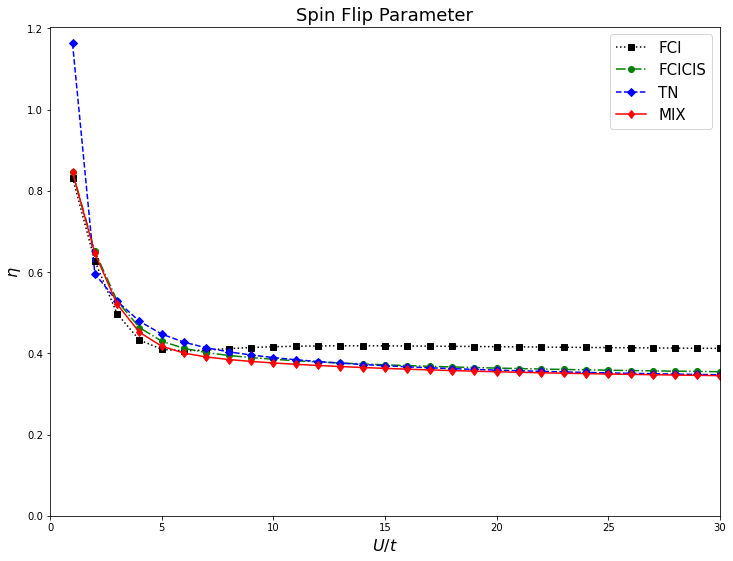

In [45]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))

plt.plot(df['U'], df['pgp-FCI'], label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], df['pgp-CIS'], label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], df['pgp-TN'], label='TN', linestyle='--', color='blue', marker='D')
plt.plot(df['U'], df['pgp-MIX'], linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\eta$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Spin Flip Parameter", fontsize=18)
plt.xlim(0,30)
plt.ylim(0)
plt.show()